# Build Gomuku (五子棋) AI with AgentScope

### --- Provided by Hongyi Peng

Gomoku is a classic board game also known as Five in a Row or 五子棋. In Gomuku, two players take turns to place stone of their color on the board and the first player who form an unbroken line of five stones of their color horizontally, vertically, or diagonally wins. 

In this example, we build AI agents capable of playing Gomuku with AgentScope.

In this example, we employ the OpenAI ChatGPT-4 model, with the configuration details stored in JSON format (stored in `openai_model_configs.json`).  

```json
{
    "config_name": "gpt-4",
    "model_type": "openai_chat",
    "model_name": "gpt-4",
    "api_key": "xxxxx",
    "organization_id": "yyyyyy",
    "generate_args": {
        "temperature": 0.1,
        "stop": "##GAMEEND##"
    }
}
```

First, we initialize agentscope and load the model.

In [13]:
from loguru import logger
from agentscope.message import Msg
from agentscope.agents import DictDialogAgent
import json
from agentscope.models import ModelResponse
import agentscope

agentscope.init(model_configs="./openai_model_configs.json")

2024-03-26 17:39:44.843 | WARNING  | agentscope.models:read_model_configs:164 - config_name [gpt-4] already exists.
2024-03-26 17:39:44.844 | INFO     | agentscope.models:read_model_configs:171 - Load configs for model wrapper: gpt-4


[]

### Prepare a board for Gomoku

As the first thing, we need to prepare a board for Gomoku. Since Gomoku is played on a 19x19 grid, we can utilize a NumPy matrix to represent and track the board's status, and wrap it as a Board class.

In [15]:

class Board:
    def __init__(self,
                 players: list = ['Alice', 'Bob'],
                 size: int = 19):
        # A move class to record the move of each player
        self.players = players
        self.size = size
        self.board = np.full((size, size), None)
        self._history = []

    # 检查是否合法落子
    def is_valid_move(self, x: int, y: int) -> bool:
        return 0 <= x < self.size and 0 <= y < self.size and self.board[x, y] is None

    # 检查是否胜利
    def check_win(self, player: str, x: int, y: int) -> bool:
        player_mask = self.board == player
        directions = [(0, 1), (1, 0), (1, 1), (-1, 1)]
        for dx, dy in directions:
            count = 1
            for sign in [-1, 1]:
                step = 1
                while True:
                    r, c = x + step * dx * sign, y + step * dy * sign
                    if 0 <= r < self.size and 0 <= c < self.size and player_mask[r, c]:
                        count += 1
                        step += 1
                    else:
                        break
            if count >= 5:
                return True
        return False

    def check_draw(self):
        return np.all(self.board != None)

    # 记录新的一步
    def add_move(self, player: str, x: int, y: int):
        assert player in self.players, f"player must be one of {self.players}"
        if not self.is_valid_move(x, y):
            raise ValueError(f"Invalid move at ({x}, {y})")
        else:
            self.board[x, y] = self.players.index(player)
            move = {'player': player, 'x': x, 'y': y}
            self._history.append(move)
            if self.check_win(player, x, y):
                print(f"{player} wins!")

To record the game status for AI agent players, it's crucial to provide them with the current state of the board. By parsing this matrix into a formatted text prompt, we can effectively feed the board's current state to the AI agents, enabling them to make informed decisions during gameplay.

In [16]:
def board2text(board: np.ndarray) -> str:
    # Initialize dictionaries to hold positions for 'O' and 'X'
    occupied_positions = {'O': [], 'X': []}
    for (row, col), player_id in np.ndenumerate(board):
        if player_id == 0:  # Player 1
            occupied_positions['O'].append(f"({row}, {col})")
        elif player_id == 1:  # Player 2
            occupied_positions['X'].append(f"({row}, {col})")
    # Prepare the result string
    result = []
    for player_symbol, positions in occupied_positions.items():
        if positions:  # If there are any positions for this symbol
            positions_str = ", ".join(positions)
            result.append(f"{player_symbol}: {positions_str}")
        else:
            result.append(f"{player_symbol}: None")
    return "\n".join(result)

# test
sample_board = np.full((19, 19), None)
sample_board[3, 3] = 0
sample_board[5, 5] = 0
sample_board[6, 7] = 0
sample_board[6, 6] = 1
sample_board[7, 6] = 1
sample_board[8, 6] = 1
board_text = board2text(sample_board)
print(board_text)

O: (3, 3), (5, 5), (6, 7)
X: (6, 6), (7, 6), (8, 6)


### Customize `DictDialogAgent`

We need to establish a standardized communication protocol to facilitate a real match between Alice and Bob. 

This protocol should translate their outputs into actionable moves, verify the legality of these moves, and accordingly update the game board. We can explore two distinct methodologies for this purpose:

- **Structured Communication**: This method lets agents reply with more structured and formatted output. A dedicated helper class would then interpret these outputs, make validity judgments on moves, and perform the necessary parsing.
- **Natural Language Interface**: Alternatively, we could delegate the entire communication and decision-making process to another agent

Let's try the first approach at first, and `DictDialogAgent` can be a good starting point. 

In [17]:
class GomokuAgent(DictDialogAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    # override the reply method
    # The same as the reply function of the DictDialogAgent
    def reply(self, x):
        if self.memory:
            self.memory.add(x)

        prompt = self.engine.join(
            self.sys_prompt,
            self.memory and self.memory.get_memory(),
        )

        # 调用大模型产生回答
        response = self.model(
            prompt,
            parse_func=self.parse_func,
            fault_handler=self.fault_handler,
            max_retries=self.max_retries,
        ).raw

        # In this agent, if the response is a dict, we treat "speak" as a special key, which represents the text to be spoken
        if isinstance(response, dict) and "speak" in response:
            msg = Msg(self.name, response["speak"], **response)
        else:
            msg = Msg(self.name, response)

        # Print/speak the message in this agent's voice
        self.speak(msg)
        # record to memory
        if self.memory:
            # Convert the response dict into a string to store in memory
            msg_memory = Msg(
                name=self.name,
                content=json.dumps(msg.content),
                role="assistant",
            )
            self.memory.add(msg_memory)
        return msg

### Prepare prompt for the agent to play Gomoku

In [18]:
SYS_PROMPT_TEMPLATE = (
"You're a skillful Gomoku player. This Gomoku board is a 19*19 grid. Moves are made by specifying row and column indexes, with (0, 0) marking the top-left corner and (19, 19) indicating the bottom-right corner. "
"Your pieces are represented by '{}', your opponent's by '{}'. Each round the positions occupied by both your and the opponent's pieces will be provided to you."
"Think carefully both about your moves and your opponent's subsequent moves. Read from the current board and make sure you don't place your piece on the spot that has been occupied. "
"You shold also state the strategy and the thinking behind your moves."
"Make sure your reply only contain the following content formatted in way which can be directly loaded by python json.loads()\n"
    "{{\n"
    '"row": "a integer indicating the rol index of your move", \n' 
    '"col": "an interger indicating the coil index of your move", \n'
    '"thoughts": "Your thoughts and strategy behind the move",\n'
    "}}"
)
NOTIFY_INVALID_PROMPT_TEMPLATE = "That move at ({}, {}) is not valid as it targets a non-empty cell. Let's try another spot.\n"

CURRENT_BOARD_PROMPT_TEMPLATE = (
"The current board is as follows:\n"
"{}\n"
"What's your next move?\n"
)


### Prepare parseing function to extract information from agent's responses

In [19]:
def parse_func(response):
    parsed_response = json.loads(response.text)
    return ModelResponse(raw=parsed_response)


# Basically did nothing
def naive_fault_response(response: ModelResponse) -> ModelResponse:
    print("Fail to parse the response")
    return response

### Create two player agents

Now, let's create two AI agents, named "Alice" and "Bob," who will engage in the Gomuku game. Creating agents is straightforward. 

In [20]:
alice = GomokuAgent("Alice",
                    model_config_name='gpt-4',
                    sys_prompt=SYS_PROMPT_TEMPLATE.format("O", "X"),
                    use_memory=True,
                    parse_func=parse_func,
                    fault_handler=naive_fault_response)
bob = GomokuAgent("Bob",
                  model_config_name='gpt-4',
                  sys_prompt=SYS_PROMPT_TEMPLATE.format("X", "O"),
                  use_memory=True,
                  parse_func=parse_func,
                  fault_handler=naive_fault_response)

2024-03-26 17:41:54.203 | INFO     | agentscope.models.model:__init__:256 - Initialize model [gpt-4]
2024-03-26 17:41:54.207 | INFO     | agentscope.models.model:__init__:256 - Initialize model [gpt-4]


### Show the Board as image

To provide more fun, we can also add a function to print/show the Board as image.

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def board2img(board:np.ndarray, save_path:str)->str:
    size = board.shape[0]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, size - 1)
    ax.set_ylim(0, size - 1)
    for i in range(size):
        ax.axhline(i, color='black', linewidth=1)
        ax.axvline(i, color='black', linewidth=1)
    for y in range(size):
        for x in range(size):
            if board[y, x] == 0:  # 'O' player
                circle = patches.Circle((x, y), 0.45, 
                                        edgecolor='black', 
                                        facecolor='black',
                                        zorder=10)
                ax.add_patch(circle)
            elif board[y, x] == 1:  # 'X' player
                circle = patches.Circle((x, y), 0.45, 
                                        edgecolor='black', 
                                        facecolor='white',
                                        zorder=10)
                ax.add_patch(circle)
    # Hide the axes and invert the y-axis
    ax.set_xticks(range(size))
    ax.set_yticks(range(size))
    ax.set_xticklabels(range(size))
    ax.set_yticklabels(range(size))
    ax.invert_yaxis()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)  # Close the figure to free memory
    return save_path

### Start the Gomoku game

Round 1
Alice: {'row': 9, 'col': 9, 'thoughts': 'The center of the board is the most strategic initial location, allowing for maximum flexibility in any direction on subsequent moves.'}
Alice: Move: (9, 9) 
Thoghts: The center of the board is the most strategic initial location, allowing for maximum flexibility in any direction on subsequent moves.


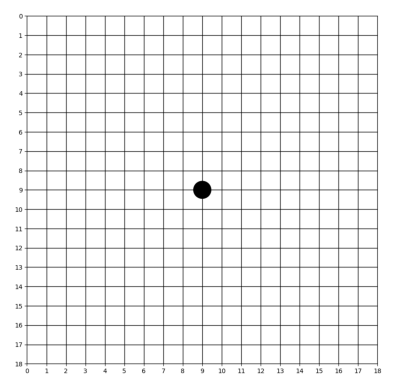

----------------------------
Round 2
Bob: Move: (10, 10) 
Thoghts: Placing my piece at (10,10) next to the opponent's piece, to develop my own cluster, and also to counter and cut down opponent's freedom to extend.Bob: {'row': 10, 'col': 10, 'thoughts': "Placing my piece at (10,10) next to the opponent's piece, to develop my own cluster, and also to counter and cut down opponent's freedom to extend."}


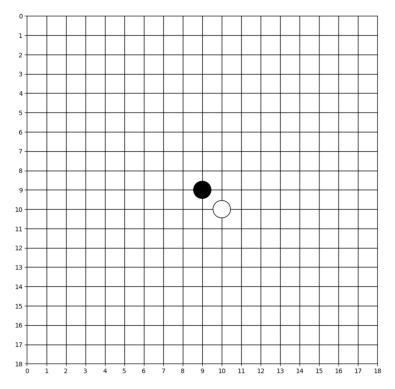

----------------------------
Round 3
Alice: Move: (8, 9) 
Thoghts: I will start to form a line by placing my piece near my first one. This also keeps my piece between the opponent's piece and the center of the board.
Alice: {'row': 8, 'col': 9, 'thoughts': "I will start to form a line by placing my piece near my first one. This also keeps my piece between the opponent's piece and the center of the board."}


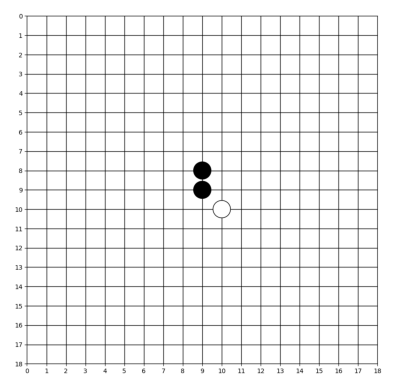

----------------------------
Round 4
Bob: Move: (10, 9) 
Thoghts: Opponent is trying to build a vertical line, I'll block him at (10,9). This not only hinders his plan but also gives me a potential to develop horizontally.Bob: {'row': 10, 'col': 9, 'thoughts': "Opponent is trying to build a vertical line, I'll block him at (10,9). This not only hinders his plan but also gives me a potential to develop horizontally."}


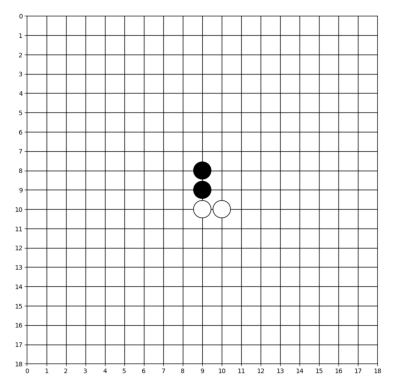

----------------------------
Round 5
Alice: Move: (8, 10) 
Thoghts: Placing a piece here will block the opponent’s vertical line while also creating more opportunities for me to create vertical or diagonal lines since it is close to my other piece.Alice: {'row': 8, 'col': 10, 'thoughts': 'Placing a piece here will block the opponent’s vertical line while also creating more opportunities for me to create vertical or diagonal lines since it is close to my other piece.'}


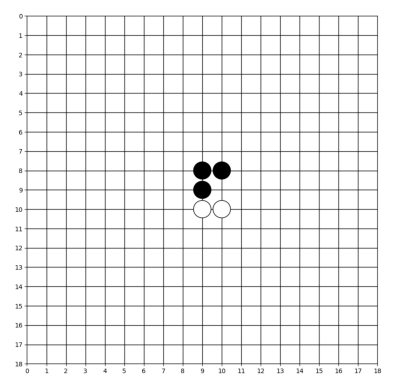

----------------------------
Round 6
Bob: Move: (10, 8) 
Thoghts: Opponent is trying to build an oblique line, I'll block him at (10,8). This not only hinders his plan but also gives me a potential to develop horizontally.Bob: {'row': 10, 'col': 8, 'thoughts': "Opponent is trying to build an oblique line, I'll block him at (10,8). This not only hinders his plan but also gives me a potential to develop horizontally."}


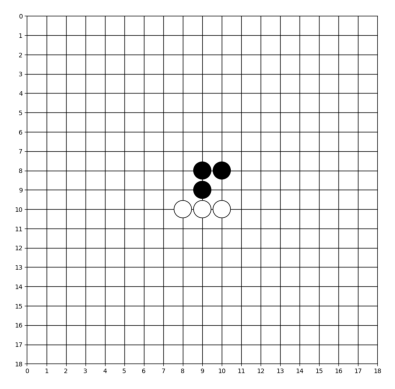

----------------------------


In [23]:
MAX_ROUND = 6 # For demonstration, we limit the game to 5 rounds
BOARD_SIZE  = 19
game = Board(players=[alice.name, bob.name], size=BOARD_SIZE)
players = [alice, bob]
current_player_idx = 0
got_winner = False # Flag to indicate if a player has won
is_draw = False # Flag to indicate if the game is a draw
for round in range(MAX_ROUND):
    print(f"Round {round + 1}")
    if not got_winner and not is_draw:
        current_player = players[current_player_idx]  # Assuming players are functions
        current_player_name = current_player.name
        current_board_text = board2text(game.board)
        prompt = CURRENT_BOARD_PROMPT_TEMPLATE.format(current_board_text)
        valid_move = False
        while not valid_move:
            reply = current_player(prompt)
            row, col = reply.content.get('row'), reply.content.get('col')
            thoughts = reply.content.get('thoughts')
            print(f"{current_player_name}: Move: {(row, col)} \nThoghts: {thoughts}")
            if game.is_valid_move(row, col):
                game.add_move(current_player_name, row, col)
                valid_move = True
            else:
                print(f'Invalid move detected at ({row}, {col}). Ask the player to make another move.')
                prompt = current_player.engine.join(NOTIFY_INVALID_PROMPT_TEMPLATE.format(row, col),
                                                    CURRENT_BOARD_PROMPT_TEMPLATE.format(current_board_text))
        got_winner = game.check_win(current_player_name, row, col)
        is_draw = game.check_draw()
        if got_winner:
            print(f"{current_player_name} wins!")
            break
        if is_draw:
            print("It's a draw!")
            break
        # Display the board image
        board_img = board2img(game.board, 'current_board.png')
        img = plt.imread(board_img)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # print a seperate line
        print("-" * 28)
        # Switch to the next player
        current_player_idx = (current_player_idx + 1) % len(players)

## Future direction
Currently, the GomokuAgent seems not that smart. Thus, it will be an interesting future direction to make the agent more human-like when playing this Gomoku game.